In [1]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from detoxify import Detoxify
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import crossprob
from tqdm import tqdm
import random
from matplotlib.ticker import FormatStrFormatter

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from matplotlib import style
plt.style.use('seaborn-v0_8')

/opt/conda/envs/prompt_risk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_bound(n, c, *, k=0):
    i = np.arange(1, n + 1)
    b = scipy.special.betaincinv(i, n - i + 1, c)
    b[:k] = 0.0
    return b

def berk_jones_bound(n, delta, *, k=0):
    def f(c):
        return crossprob.ecdf1_new_b(get_bound(n, c, k=k)) - (1 - delta)
    
    return get_bound(n, scipy.optimize.bisect(f, 0.0, 1.0), k=k)

def ecdf(xs, data):
    return np.mean(np.expand_dims(data, -1) <= xs, -2)

def integrate_quantiles(X, b, beta_min=0.0, beta_max=1.0):
    dist_max = 1.0
    X_sorted = np.sort(X, axis=-1)
    b_lower = np.concatenate([np.zeros(1), b], -1)
    b_upper = np.concatenate([b, np.ones(1)], -1)
    
    # clip bounds to [beta_min, 1]
    b_lower = np.maximum(b_lower, beta_min)
    b_upper = np.maximum(b_upper, b_lower)
    
    # clip bounds to [0, beta_max]
    b_upper = np.minimum(b_upper, beta_max)
    b_lower = np.minimum(b_upper, b_lower)

    heights = b_upper - b_lower
    widths = np.concatenate([X_sorted, np.full((X_sorted.shape[0], 1), dist_max)], -1)
    return np.sum(heights * widths, -1) / (beta_max - beta_min)

In [3]:
instructions = [
    "Generate a concise summary that captures the main points of the given text.",
    "Summarize the content while maintaining its original context and key details.",
    "Create a brief summary that effectively conveys the central theme and important information.",
    "Craft a summary that is clear, coherent, and provides a condensed version of the text.",
    "Summarize the text in a way that is informative and easy for readers to understand.",
    "Generate a summary that highlights the most significant aspects of the text.",
    "Create a summary that retains the essential ideas while reducing the overall length.",
    "Summarize the text while preserving the logical flow and logical connections between ideas.",
    "Craft a concise summary that captures the core concepts and avoids unnecessary details.",
    "Generate a summary that offers a quick overview of the main points covered in the text."
    "Generate a concise summary while preserving the key details and main ideas.",
    "Summarize the content into a short, coherent passage that captures the essence of the text.",
    "Craft a summary that distills the main points while maintaining the original context.",
    "Create a brief summary that effectively communicates the central theme and important information.",
    "Summarize the text in a way that conveys its core concepts and essential takeaways.",
    "Generate a summary that highlights the most significant aspects of the text, avoiding unnecessary details.",
    "Craft a concise summary that captures the essential ideas and logical flow of the content.",
    "Summarize the text while maintaining logical connections between ideas for clarity.",
    "Create a summary that provides a clear overview of the text's main arguments and conclusions.",
    "Generate a summary that concisely conveys the author's main message and supporting points.",
    "Craft a coherent summary that presents the main ideas succinctly and accurately.",
    "Summarize the text by condensing the content into a brief and informative passage.",
    "Create a summary that captures the author's key insights, opinions, and evidence.",
    "Generate a concise summary that offers a comprehensive view of the text's content.",
    "Craft a summary that effectively communicates the text's purpose, main points, and implications.",
    "Summarize the text by identifying and summarizing the major sections or topics.",
    "Create a clear and concise summary that avoids unnecessary repetition.",
    "Generate a summary that provides readers with an understanding of the text's main themes.",
    "Craft a summary that emphasizes the most relevant details and overarching narrative.",
    "Summarize the text by selecting the most crucial information and insights.",
    "Create a summary that captures the text's essence while ensuring readability and coherence.",
    "Generate a summary that condenses the text's content without altering its intended meaning.",
    "Craft a summary that represents the text's main points while maintaining its original tone.",
    "Summarize the text in a way that presents a balanced view of different perspectives, if applicable.",
    "Create a concise summary that succinctly conveys the text's significance and implications.",
    "Generate a summary that avoids personal bias and focuses on the objective content.",
    "Craft a summary that provides a clear overview of the text's structure and content flow.",
    "Summarize the text by identifying the primary goals, outcomes, or conclusions.",
    "Create a summary that captures the text's essential takeaways, making it accessible to readers.",
    "Generate a concise summary that effectively communicates the text's core message and insights.",
    "Craft a summary that highlights the text's relevance, significance, and potential impact."
]

In [4]:
device = "cuda:2"
delta = 0.05
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
random_seed = 42
batch_size=32
n_total=1000

In [5]:
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [6]:
chat_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to(device)
chat_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
chat_model.eval()
print("chat model loaded")

chat model loaded


In [7]:
import evaluate

bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

In [8]:
res = []

In [9]:
for instruction in instructions:

    random.seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    ins_root = instruction + " Summarize the following document: \n (Document): "

    dataset = load_dataset("xsum")["test"]
    
    def prepend(batch):
        batch["text"] = [ins_root + t for t in batch["document"]]
        return batch

    dataset = dataset.map(prepend, batched=True)
    dataset = dataset.with_format("torch")
    val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    X = []
    with torch.no_grad():

        for batch in val_dataloader:

            inputs = chat_tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = chat_model.generate(**inputs, max_length=100)
            chat_out = chat_tokenizer.batch_decode(outputs, skip_special_tokens=True)
            
            score_out = bertscore.compute(predictions=chat_out, references=batch["summary"], lang="en")["f1"]
            score_out = 1-np.array(score_out)
            score_out = list(score_out)
            
            X.extend(score_out)
            
            if len(X) > n_total:
                break

    X = np.array(X)

    print("Instruction:", instruction)
    print("X", X.shape)
    print(X)
    print()

    res.append([instruction, X])

Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96302.80 examples/s]


Instruction: Generate a concise summary that captures the main points of the given text.
X (1024,)
[0.14838862 0.09283537 0.11385715 ... 0.11750734 0.10129523 0.0451684 ]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 95215.50 examples/s]


Instruction: Summarize the content while maintaining its original context and key details.
X (1024,)
[0.13959187 0.11066103 0.11385727 ... 0.11750734 0.09819472 0.03758496]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 92857.56 examples/s]


Instruction: Create a brief summary that effectively conveys the central theme and important information.
X (1024,)
[0.13959163 0.11066103 0.11385715 ... 0.11750734 0.10129511 0.03215915]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94248.23 examples/s]


Instruction: Craft a summary that is clear, coherent, and provides a condensed version of the text.
X (1024,)
[0.13959163 0.11066103 0.11046946 ... 0.11750734 0.09819466 0.03758508]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96039.57 examples/s]


Instruction: Summarize the text in a way that is informative and easy for readers to understand.
X (1024,)
[0.13959169 0.1056143  0.1104694  ... 0.11750734 0.10843951 0.04516828]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94387.08 examples/s]


Instruction: Generate a summary that highlights the most significant aspects of the text.
X (1024,)
[0.13959163 0.10561419 0.11046946 ... 0.11750734 0.09804714 0.03758508]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 93450.63 examples/s]


Instruction: Create a summary that retains the essential ideas while reducing the overall length.
X (1024,)
[0.14838862 0.10561419 0.11046946 ... 0.11750734 0.10853487 0.09348273]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 95150.51 examples/s]


Instruction: Summarize the text while preserving the logical flow and logical connections between ideas.
X (1024,)
[0.13959163 0.11066103 0.11046946 ... 0.11750734 0.10843951 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96701.65 examples/s]


Instruction: Craft a concise summary that captures the core concepts and avoids unnecessary details.
X (1024,)
[0.14838862 0.11066103 0.11385715 ... 0.11750734 0.10853487 0.03215915]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94877.05 examples/s]


Instruction: Generate a summary that offers a quick overview of the main points covered in the text.Generate a concise summary while preserving the key details and main ideas.
X (1024,)
[0.14838862 0.10561419 0.11046946 ... 0.11750734 0.09804714 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96062.47 examples/s]


Instruction: Summarize the content into a short, coherent passage that captures the essence of the text.
X (1024,)
[0.10732913 0.1068455  0.11046946 ... 0.11460459 0.11804247 0.09940398]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97258.58 examples/s]


Instruction: Craft a summary that distills the main points while maintaining the original context.
X (1024,)
[0.13959163 0.11066103 0.11385721 ... 0.11750734 0.10129523 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97090.33 examples/s]


Instruction: Create a brief summary that effectively communicates the central theme and important information.
X (1024,)
[0.13959163 0.11066103 0.11385715 ... 0.11750734 0.10129523 0.03215915]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94777.37 examples/s]


Instruction: Summarize the text in a way that conveys its core concepts and essential takeaways.
X (1024,)
[0.13959163 0.1056143  0.11046946 ... 0.11750734 0.09703559 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97331.06 examples/s]


Instruction: Generate a summary that highlights the most significant aspects of the text, avoiding unnecessary details.
X (1024,)
[0.14838862 0.10561419 0.11046946 ... 0.11750734 0.10915357 0.03758508]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 95860.24 examples/s]


Instruction: Craft a concise summary that captures the essential ideas and logical flow of the content.
X (1024,)
[0.13959163 0.11066103 0.11046946 ... 0.11750734 0.12237287 0.03215909]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97053.66 examples/s]


Instruction: Summarize the text while maintaining logical connections between ideas for clarity.
X (1024,)
[0.09489679 0.11066103 0.11385715 ... 0.11750734 0.09819466 0.03758508]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97587.01 examples/s]


Instruction: Create a summary that provides a clear overview of the text's main arguments and conclusions.
X (1024,)
[0.14838862 0.11159003 0.11046946 ... 0.11750734 0.10915357 0.09348279]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 95090.94 examples/s]


Instruction: Generate a summary that concisely conveys the author's main message and supporting points.
X (1024,)
[0.14838862 0.10561419 0.11046946 ... 0.11750734 0.10915357 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94887.09 examples/s]


Instruction: Craft a coherent summary that presents the main ideas succinctly and accurately.
X (1024,)
[0.13959163 0.11066103 0.11046946 ... 0.11750734 0.09782577 0.03758508]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96373.28 examples/s]


Instruction: Summarize the text by condensing the content into a brief and informative passage.
X (1024,)
[0.14909828 0.1068455  0.11717433 ... 0.11460453 0.11428487 0.09940398]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94999.53 examples/s]


Instruction: Create a summary that captures the author's key insights, opinions, and evidence.
X (1024,)
[0.1270144  0.11066103 0.11046946 ... 0.11750734 0.10843945 0.03215915]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97189.98 examples/s]


Instruction: Generate a concise summary that offers a comprehensive view of the text's content.
X (1024,)
[0.10305333 0.10561419 0.11046946 ... 0.11750734 0.11911297 0.03215915]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97151.84 examples/s]


Instruction: Craft a summary that effectively communicates the text's purpose, main points, and implications.
X (1024,)
[0.13959163 0.12653607 0.11046946 ... 0.11750734 0.10915357 0.03758508]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94986.63 examples/s]


Instruction: Summarize the text by identifying and summarizing the major sections or topics.
X (1024,)
[0.10305333 0.12653607 0.11385715 ... 0.11750734 0.09782583 0.0451684 ]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96338.52 examples/s]


Instruction: Create a clear and concise summary that avoids unnecessary repetition.
X (1024,)
[0.14838862 0.12653607 0.11385715 ... 0.11750734 0.09962213 0.03215909]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97288.43 examples/s]


Instruction: Generate a summary that provides readers with an understanding of the text's main themes.
X (1024,)
[0.09489679 0.10561419 0.11046946 ... 0.11750734 0.10843951 0.03758508]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97523.94 examples/s]


Instruction: Craft a summary that emphasizes the most relevant details and overarching narrative.
X (1024,)
[0.10305333 0.11066103 0.11046946 ... 0.11750734 0.10853481 0.0451684 ]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97518.94 examples/s]


Instruction: Summarize the text by selecting the most crucial information and insights.
X (1024,)
[0.10305339 0.09296995 0.11385727 ... 0.08964616 0.09810066 0.09940398]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96155.54 examples/s]


Instruction: Create a summary that captures the text's essence while ensuring readability and coherence.
X (1024,)
[0.13959163 0.11066103 0.11046946 ... 0.11750734 0.09703559 0.03215909]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94926.50 examples/s]


Instruction: Generate a summary that condenses the text's content without altering its intended meaning.
X (1024,)
[0.13959169 0.11419529 0.11385727 ... 0.11750734 0.09819466 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 97198.72 examples/s]


Instruction: Craft a summary that represents the text's main points while maintaining its original tone.
X (1024,)
[0.13959169 0.11066097 0.11385727 ... 0.11750734 0.09782577 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 95500.51 examples/s]


Instruction: Summarize the text in a way that presents a balanced view of different perspectives, if applicable.
X (1024,)
[0.09489679 0.10355258 0.11046946 ... 0.11840647 0.11116147 0.04516828]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96217.23 examples/s]


Instruction: Create a concise summary that succinctly conveys the text's significance and implications.
X (1024,)
[0.13959163 0.11066103 0.11046946 ... 0.11750734 0.09703559 0.03215909]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 95663.47 examples/s]


Instruction: Generate a summary that avoids personal bias and focuses on the objective content.
X (1024,)
[0.14838862 0.10561419 0.11046946 ... 0.11750734 0.09782577 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 95823.33 examples/s]


Instruction: Craft a summary that provides a clear overview of the text's structure and content flow.
X (1024,)
[0.13959163 0.09283537 0.11046946 ... 0.11750734 0.10915357 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96429.19 examples/s]


Instruction: Summarize the text by identifying the primary goals, outcomes, or conclusions.
X (1024,)
[0.10305333 0.09296232 0.11385715 ... 0.11750734 0.10853481 0.04516846]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96339.69 examples/s]


Instruction: Create a summary that captures the text's essential takeaways, making it accessible to readers.
X (1024,)
[0.13959163 0.10561419 0.11385715 ... 0.11750734 0.09703559 0.03215915]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 96557.29 examples/s]


Instruction: Generate a concise summary that effectively communicates the text's core message and insights.
X (1024,)
[0.13959163 0.10561419 0.11046946 ... 0.11750734 0.11814338 0.03215915]



Map: 100%|████████████████████████████████████| 11334/11334 [00:00<00:00, 94230.86 examples/s]


Instruction: Craft a summary that highlights the text's relevance, significance, and potential impact.
X (1024,)
[0.10305333 0.11066103 0.11385715 ... 0.11750734 0.09782577 0.03758508]



In [10]:
##### SAVE DATA!

In [11]:
bj_bounds = dict()
correction = delta/len(instructions)

In [20]:
def plot_results(
    beta_min, 
    beta_max, 
    n_cal_list=[200,1000],
    top_row=False
):

    n_plots = len(n_cal_list)

    plt.rcParams["figure.figsize"] = [6*n_plots,3]

    fig, axs = plt.subplots(1,n_plots)

    for n_idx, n_cal in enumerate(n_cal_list):
    
        stats = []
        
        for instruction, X in res:
               
            X_cal = X[:n_cal]
            X_test = X[n_cal:]
            n_test = X_test.shape[0]
            assert X_cal.shape[0] == n_cal and X_test.shape[0] == n_test
        
            if X_cal.shape[0] not in bj_bounds:
                b = berk_jones_bound(n_cal, correction)
                bj_bounds[n_cal] = b
            else:
                b = bj_bounds[n_cal]
            
            t_cal = np.linspace(0.0, 1.0, n_cal)
            X_cal_sorted = np.sort(X_cal, axis=-1)
            
            t_test = np.linspace(0.0, 1.0, n_test)
            X_test_sorted = np.sort(X_test, axis=-1)

        
            mean_bound = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=0.0, beta_max=1.0)[0]
            cvar_bound = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=beta_min, beta_max=beta_max)[0]
            
            emp_mean_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=0.0, beta_max=1.0)[0]
            emp_cvar_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=beta_min, beta_max=beta_max)[0]
            
            emp_mean_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=0.0, beta_max=1.0)[0]
            emp_cvar_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=beta_min, beta_max=beta_max)[0]

            stats.append([instruction, mean_bound, cvar_bound, emp_mean_cal, emp_cvar_cal, emp_mean_test, emp_cvar_test])

            # plt.plot(X_cal_sorted, b, label="bound")
            # plt.plot(X_cal_sorted, t_cal, label="empirical (cal)")
            # plt.plot(X_test_sorted, t_test, label="empirical (test)")
            # plt.legend()
            # plt.show()
        
            # print("bound mean", mean_bound, "| bound cvar", cvar_bound)
            # print("emp mean (cal)", emp_mean_cal, "| emp cvar (cal)", emp_cvar_cal)
            # print("emp mean (test)", emp_mean_test, "| emp cvar (test)", emp_cvar_test)
            # print()
            # print()
        
        x_plot = []
        y_plot = []
        
        
        for s in stats:
        
            instruction, mean_bound, cvar_bound, emp_mean_cal, emp_cvar_cal, emp_mean_test, emp_cvar_test = s
        
            x_plot.append(emp_mean_cal)
            y_plot.append(cvar_bound)
        
        axs[n_idx].scatter(x_plot, y_plot, alpha=0.8, color=pal[2], label="Prompt")
        
        axs[n_idx].set_xlabel("Empirical Mean on Val. Set")
        axs[n_idx].set_ylabel("Bound")
        
        if beta_max == 1:
            axs[n_idx].set_title(r"CVaR ($n={}, \beta={}$)".format(n_cal, beta_min))
        else:
            axs[n_idx].set_title(r"VaR-Interval ($n={}, \beta_l={}, \beta_u={}$)".format(n_cal, beta_min, beta_max))

        axs[n_idx].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

        if n_idx == 1 and not top_row:
            axs[n_idx].legend(fontsize=12)

    if top_row:
        plt.suptitle("Summarization - Bert Score Loss", y=1.05)
        
    plt.savefig("../plots/summarization_{}_{}.png".format(beta_min, beta_max), bbox_inches="tight")
    plt.show()
        
            

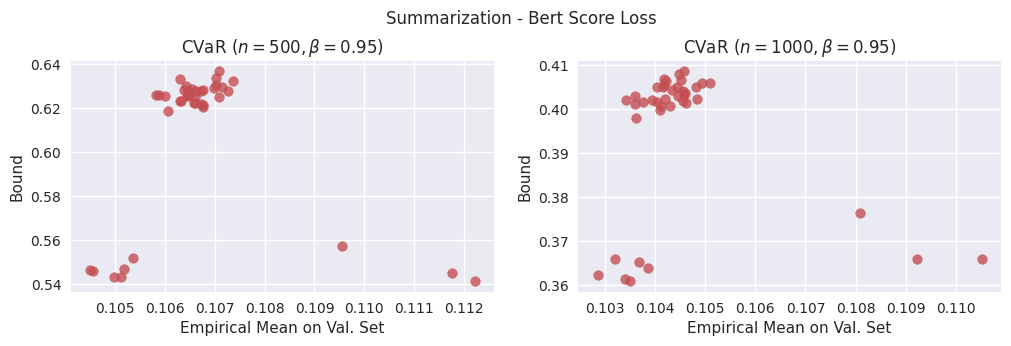

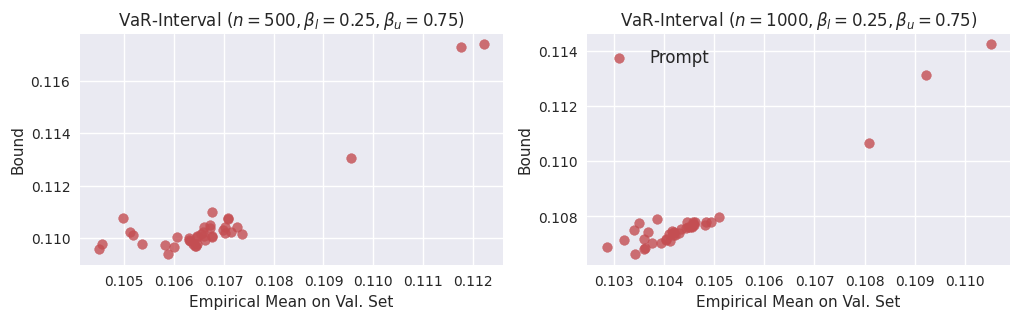

In [21]:
plot_results(
    beta_min = 0.95,
    beta_max = 1.0, 
    n_cal_list = [500, 1000],
    top_row=True
)

plot_results(
    beta_min = 0.25,
    beta_max = 0.75, 
    n_cal_list = [500, 1000]
)